In [1]:
import requests
import math
import pandas as pd
import folium
from datetime import datetime
from folium.plugins import MarkerCluster

In [2]:
class SVY21:
    # Ref: https://github.com/cgcai/SVY21/blob/master/Python/SVY21.py

    # WGS84 Datum
    a = 6378137
    f = 1 / 298.257223563

    # SVY21 Projection
    # Fundamental point: Base 7 at Pierce Resevoir.
    # Latitude: 1 22 02.9154 N, longitude: 103 49 31.9752 E (of Greenwich).

    # Known Issue: Setting (oLat, oLon) to the exact coordinates specified above
    # results in computation being slightly off. The values below give the most
    # accurate represenation of test data.
    oLat = 1.366666  # origin's lat in degrees
    oLon = 103.833333  # origin's lon in degrees
    oN = 38744.572  # false Northing
    oE = 28001.642  # false Easting
    k = 1  # scale factor

    #
    def __init__(self):
        self.b = self.a * (1 - self.f)
        self.e2 = (2 * self.f) - (self.f * self.f)
        self.e4 = self.e2 * self.e2
        self.e6 = self.e4 * self.e2
        self.A0 = 1 - (self.e2 / 4) - (3 * self.e4 / 64) - (5 * self.e6 / 256);
        self.A2 = (3. / 8.) * (self.e2 + (self.e4 / 4) + (15 * self.e6 / 128));
        self.A4 = (15. / 256.) * (self.e4 + (3 * self.e6 / 4));
        self.A6 = 35 * self.e6 / 3072;

    def calcM(self, lat):
        latR = lat * math.pi / 180
        return self.a * ((self.A0 * latR) - (self.A2 * math.sin(2 * latR)) + (self.A4 * math.sin(4 * latR)) - (
                self.A6 * math.sin(6 * latR)))

    def calcRho(self, sin2Lat):
        num = self.a * (1 - self.e2)
        denom = math.pow(1 - self.e2 * sin2Lat, 3. / 2.)
        return num / denom

    def calcV(self, sin2Lat):
        poly = 1 - self.e2 * sin2Lat
        return self.a / math.sqrt(poly)

    def computeLatLon(self, E, N):
        """
        Returns a pair (lat, lon) representing Latitude and Longitude.
        """
        N = float(N)
        E = float(E)
        Nprime = N - self.oN
        Mo = self.calcM(self.oLat)
        Mprime = Mo + (Nprime / self.k)
        n = (self.a - self.b) / (self.a + self.b)
        n2 = n * n
        n3 = n2 * n
        n4 = n2 * n2
        G = self.a * (1 - n) * (1 - n2) * (1 + (9 * n2 / 4) + (225 * n4 / 64)) * (math.pi / 180)
        sigma = (Mprime * math.pi) / (180. * G)

        latPrimeT1 = ((3 * n / 2) - (27 * n3 / 32)) * math.sin(2 * sigma)
        latPrimeT2 = ((21 * n2 / 16) - (55 * n4 / 32)) * math.sin(4 * sigma)
        latPrimeT3 = (151 * n3 / 96) * math.sin(6 * sigma)
        latPrimeT4 = (1097 * n4 / 512) * math.sin(8 * sigma)
        latPrime = sigma + latPrimeT1 + latPrimeT2 + latPrimeT3 + latPrimeT4

        sinLatPrime = math.sin(latPrime)
        sin2LatPrime = sinLatPrime * sinLatPrime

        rhoPrime = self.calcRho(sin2LatPrime)
        vPrime = self.calcV(sin2LatPrime)
        psiPrime = vPrime / rhoPrime
        psiPrime2 = psiPrime * psiPrime
        psiPrime3 = psiPrime2 * psiPrime
        psiPrime4 = psiPrime3 * psiPrime
        tPrime = math.tan(latPrime)
        tPrime2 = tPrime * tPrime
        tPrime4 = tPrime2 * tPrime2
        tPrime6 = tPrime4 * tPrime2
        Eprime = E - self.oE
        x = Eprime / (self.k * vPrime)
        x2 = x * x
        x3 = x2 * x
        x5 = x3 * x2
        x7 = x5 * x2

        # Compute Latitude
        latFactor = tPrime / (self.k * rhoPrime)
        latTerm1 = latFactor * ((Eprime * x) / 2)
        latTerm2 = latFactor * ((Eprime * x3) / 24) * (
                (-4 * psiPrime2) + (9 * psiPrime) * (1 - tPrime2) + (12 * tPrime2))
        latTerm3 = latFactor * ((Eprime * x5) / 720) * (
                (8 * psiPrime4) * (11 - 24 * tPrime2) - (12 * psiPrime3) * (21 - 71 * tPrime2) + (
                15 * psiPrime2) * (15 - 98 * tPrime2 + 15 * tPrime4) + (180 * psiPrime) * (
                        5 * tPrime2 - 3 * tPrime4) + 360 * tPrime4)
        latTerm4 = latFactor * ((Eprime * x7) / 40320) * (1385 - 3633 * tPrime2 + 4095 * tPrime4 + 1575 * tPrime6)
        lat = latPrime - latTerm1 + latTerm2 - latTerm3 + latTerm4

        # Compute Longitude
        secLatPrime = 1. / math.cos(lat)
        lonTerm1 = x * secLatPrime
        lonTerm2 = ((x3 * secLatPrime) / 6) * (psiPrime + 2 * tPrime2)
        lonTerm3 = ((x5 * secLatPrime) / 120) * ((-4 * psiPrime3) * (1 - 6 * tPrime2) + psiPrime2 * (
                9 - 68 * tPrime2) + 72 * psiPrime * tPrime2 + 24 * tPrime4)
        lonTerm4 = ((x7 * secLatPrime) / 5040) * (61 + 662 * tPrime2 + 1320 * tPrime4 + 720 * tPrime6)
        lon = (self.oLon * math.pi / 180) + lonTerm1 - lonTerm2 + lonTerm3 - lonTerm4

        return (lat / (math.pi / 180), lon / (math.pi / 180))

In [3]:
svy=SVY21()

In [4]:
access_key="889afffc-2d89-4398-a6ae-a032530f45e2"
headers={"AccessKey": access_key,"User-Agent": "placeholder"}
res=requests.get(url="https://www.ura.gov.sg/uraDataService/insertNewToken.action",
                 headers=headers)

In [5]:
headers["Token"]=res.json()['Result']

In [6]:
parking_lot=requests.get("https://www.ura.gov.sg/uraDataService/invokeUraDS?service=Car_Park_Availability"
                         ,headers=headers)

In [7]:
parking_lot=parking_lot.json()['Result']

In [8]:
carpark=pd.DataFrame(parking_lot)

In [9]:
carpark['geo']=carpark['geometries'].apply(lambda x: [tuple(i['coordinates'].split(',')) for i in x])

In [10]:
carpark['lotType']=carpark['lotType'].map({'C':'Car','M':'Motorcycle','H':'Heavy Vehicle'})

In [11]:
parking_fare=requests.get('https://www.ura.gov.sg/uraDataService/invokeUraDS?service=Car_Park_Details'
                            ,headers=headers)

In [12]:
parking_fare=parking_fare.json()['Result']

In [13]:
parking_fare=pd.DataFrame(parking_fare)

In [14]:
parking=carpark.merge(parking_fare.drop('geometries',axis=1),
                   left_on=["carparkNo","lotType"],right_on=['ppCode','vehCat'],how='left').dropna()

In [15]:
parking.drop(['ppCode','vehCat','geometries','remarks'],axis=1,inplace=True)

In [16]:
for i in ['startTime','endTime']:
    parking[i]=parking[i].apply(lambda x: datetime.strptime(x, '%I.%M %p').time())

In [17]:
def time_in_range(start,end,x):
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

In [18]:
parking['parking_period']=[time_in_range(i['startTime'],i['endTime'],datetime.now().time()) for i in parking.iloc()]

In [19]:
parking=parking[parking['parking_period']]

In [20]:
parking['weekday']=parking['weekdayRate']+'/'+parking['weekdayMin']
parking['satday']=parking['satdayRate']+'/'+parking['satdayMin']
parking['sunPH']=parking['sunPHRate']+'/'+parking['sunPHMin']

In [21]:
parking

,carparkNo,lotsAvailable,lotType,geo,weekdayMin,weekdayRate,parkingSystem,ppName,satdayMin,satdayRate,sunPHMin,sunPHRate,startTime,parkCapacity,endTime,parking_period,weekday,satday,sunPH
3,D0026,0,Car,"[(30253.4988, 32024.8859)]",30 mins,$0.60,B,DICKSON ROAD OFF STREET,30 mins,$0.60,30 mins,$0.60,07:00:00,43.0,22:30:00,True,$0.60/30 mins,$0.60/30 mins,$0.60/30 mins
6,H0015,0,Car,"[(30308.9887, 32322.7756)]",30 mins,$0.60,B,HINDOO ROAD OFF STREET,30 mins,$0.60,30 mins,$0.60,07:00:00,12.0,22:30:00,True,$0.60/30 mins,$0.60/30 mins,$0.60/30 mins
9,J0100,52,Car,"[(23792.7911, 28505.857)]",30 mins,$0.60,B,JALAN PELEPAH OFF STREET,30 mins,$0.60,30 mins,$0.60,07:00:00,54.0,22:30:00,True,$0.60/30 mins,$0.60/30 mins,$0.60/30 mins
19,M0078,4,Motorcycle,"[(26559.0302, 27674.9872)]",930 mins,$0.65,B,MARITIME SQUARE D OFF STREET,930 mins,$0.65,930 mins,$0.65,07:00:00,414.0,22:30:00,True,$0.65/930 mins,$0.65/930 mins,$0.65/930 mins
21,P0113,12,Motorcycle,"[(23454.3672, 28648.1075)]",930 mins,$0.65,B,PASIR PANJANG FOOD CENTRE (TEMP) OFF ST,930 mins,$0.65,930 mins,$0.65,07:00:00,16.0,22:30:00,True,$0.65/930 mins,$0.65/930 mins,$0.65/930 mins
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Q0006,0,Motorcycle,"[(30230.7932, 31364.3729)]",930 mins,$0.65,B,QUEEN STREET OFF STREET,930 mins,$0.65,930 mins,$0.65,07:00:00,19.0,22:30:00,True,$0.65/930 mins,$0.65/930 mins,$0.65/930 mins
400,S0020,16,Car,"[(27499.7177, 39363.6594)]",30 mins,$0.60,B,SEMBAWANG HILLS FOOD CENTRE OFF STREET,30 mins,$0.60,30 mins,$0.60,07:00:00,18.0,22:30:00,True,$0.60/30 mins,$0.60/30 mins,$0.60/30 mins
403,T0140,10,Motorcycle,"[(34984.8879, 32129.2842)]",930 mins,$0.65,B,TANJONG KATONG ROAD OFF STREET,930 mins,$0.65,930 mins,$0.65,07:00:00,21.0,22:30:00,True,$0.65/930 mins,$0.65/930 mins,$0.65/930 mins
405,U0036,69,Car,"[(38320.451, 32726.3989)]",30 mins,$0.60,B,UPPER EAST COAST ROAD OFF STREET,30 mins,$0.60,30 mins,$0.60,07:00:00,127.0,22:30:00,True,$0.60/30 mins,$0.60/30 mins,$0.60/30 mins


In [22]:
#parking.drop_duplicates(['carparkNo','lotType','startTime','endTime'],inplace=True)

In [23]:
m = folium.Map(location=[1.290270,103.851959],zoom_start=12)

In [24]:
cluster_car = MarkerCluster(name="car").add_to(m)
cluster_motor = MarkerCluster(name="motorcycle").add_to(m)
cluster_hv = MarkerCluster(name="heavy vehicle").add_to(m)

In [25]:
for i in parking.iloc():
    for j in i['geo']:
        E,N = j
        tooltip=i['ppName']
        location=svy.computeLatLon(E,N)
        text=f"Type:{i['lotType']}<br>Lots left:{i['lotsAvailable']}<br>"+ \
        f"Weekday rates:{i['weekday']}<br>Sat rates:{i['satday']}<br>Sun/PH rates {i['sunPH']}"
        popup=folium.Popup(text,max_width=450,max_length=450)
        if (i['lotType'] == 'Car') & (i['weekdayMin'] == "510 mins"):
            icon = folium.Icon(icon='car', prefix='fa', color='orange')
            marker = folium.Marker(location=location,tooltip=tooltip,popup=popup,icon=icon)
            cluster_car.add_child(marker)
        elif (i['lotType'] == 'Car'):
            icon = folium.Icon(icon='car', prefix='fa')
            marker = folium.Marker(location=location,tooltip=tooltip,popup=popup,icon=icon)
            cluster_car.add_child(marker)
        elif i['lotType'] == 'Motorcycle':
            icon = folium.Icon(icon='motorcycle', prefix='fa')
            marker = folium.Marker(location=location,tooltip=tooltip,popup=popup,icon=icon)
            cluster_motor.add_child(marker)
        elif i['lotType'] == 'Heavy Vehicle':
            icon = folium.Icon(icon='truck', prefix='fa')
            marker = folium.Marker(location=location,tooltip=tooltip,popup=popup)
            cluster_hv.add_child(marker)
            
folium.LayerControl().add_to(m)

In [26]:
m

## Sample Image

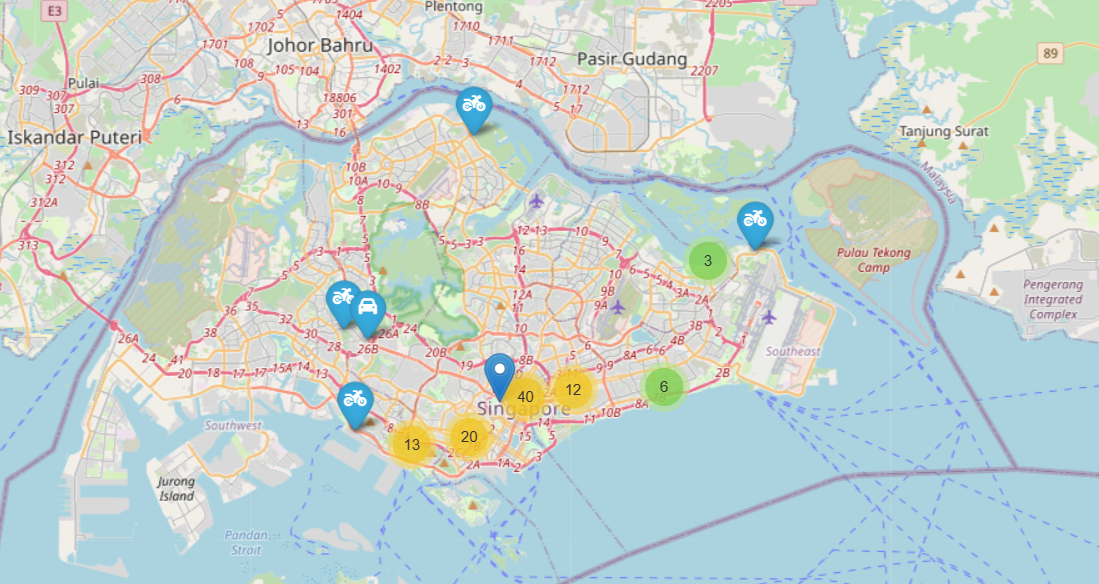